In [75]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import  LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score, accuracy_score

from sklearn.metrics import classification_report

from interpret.blackbox import LimeTabular
from interpret import show
import shap
shap.initjs()

In [163]:
df = pd.read_csv('CVD_cleaned.csv')
df.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


In [237]:
df.shape

(308854, 19)

In [238]:
df.isnull().sum()/df.shape[0] * 100

General_Health                  0.0
Checkup                         0.0
Exercise                        0.0
Heart_Disease                   0.0
Skin_Cancer                     0.0
Other_Cancer                    0.0
Depression                      0.0
Diabetes                        0.0
Arthritis                       0.0
Sex                             0.0
Age_Category                    0.0
Height_(cm)                     0.0
Weight_(kg)                     0.0
BMI                             0.0
Smoking_History                 0.0
Alcohol_Consumption             0.0
Fruit_Consumption               0.0
Green_Vegetables_Consumption    0.0
FriedPotato_Consumption         0.0
dtype: float64

In [115]:
df.describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000
mean,170.615249,83.588655,28.626211,5.096366,29.835200,15.110441,6.296616
std,10.658026,21.343210,6.522323,8.199763,24.875735,14.926238,8.582954
min,91.000000,24.950000,12.020000,0.000000,0.000000,0.000000,0.000000
25%,163.000000,68.040000,24.210000,0.000000,12.000000,4.000000,2.000000
50%,170.000000,81.650000,27.440000,1.000000,30.000000,12.000000,4.000000
75%,178.000000,95.250000,31.850000,6.000000,30.000000,20.000000,8.000000
max,241.000000,293.020000,99.330000,30.000000,120.000000,128.000000,128.000000


# EDA

In [164]:
df_no_disease = df[df['Heart_Disease'] == 'No']
df_yes_disease = df[df['Heart_Disease'] == 'Yes']

Text(0.5, 0.98, 'General Health')

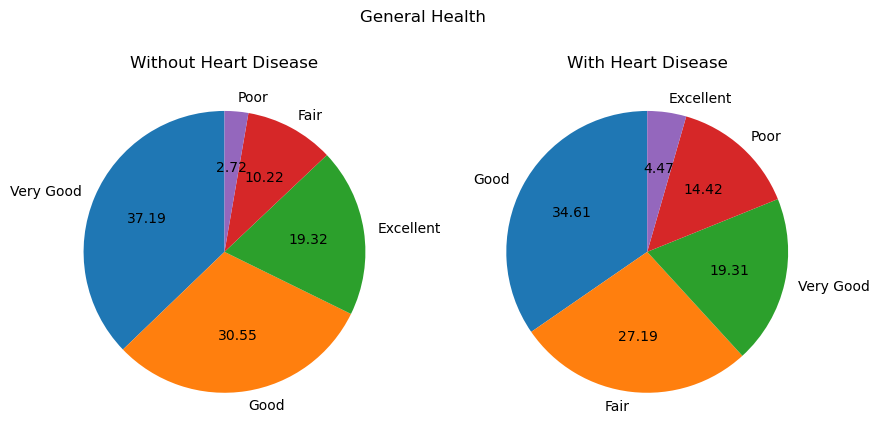

In [155]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

axs[0].pie(df_no_disease['General_Health'].value_counts(), 
           labels = df_no_disease['General_Health'].value_counts().index.tolist(),
           autopct='%.2f', 
           startangle = 90)
axs[0].set_title('Without Heart Disease')


axs[1].pie(df_yes_disease['General_Health'].value_counts(), 
           labels = df_yes_disease['General_Health'].value_counts().index.tolist(),
           autopct='%.2f', 
           startangle = 90)
axs[1].set_title('With Heart Disease')

plt.suptitle('General Health')

Text(0.5, 0.98, 'Checkup')

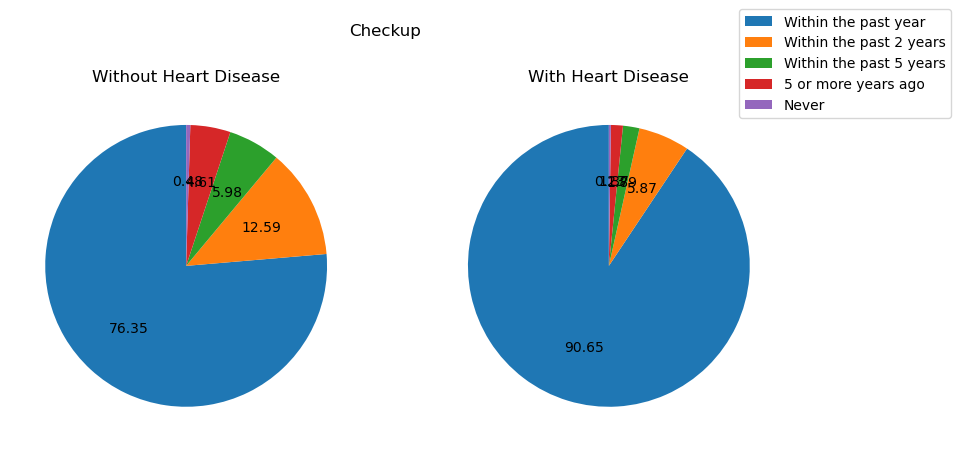

In [138]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
labels1 = df_no_disease['Checkup'].value_counts().index.tolist()
labels2 = df_yes_disease['Checkup'].value_counts().index.tolist()

axs[0].pie(df_no_disease['Checkup'].value_counts(), 
           labels = None,
           autopct='%.2f', 
           startangle = 90)
axs[0].set_title('Without Heart Disease')


axs[1].pie(df_yes_disease['Checkup'].value_counts(), 
           labels = None,
           autopct='%.2f', 
           startangle = 90)
axs[1].set_title('With Heart Disease')
plt.legend(labels1, loc='best', bbox_to_anchor=(0.85, 0.9))

plt.suptitle('Checkup')

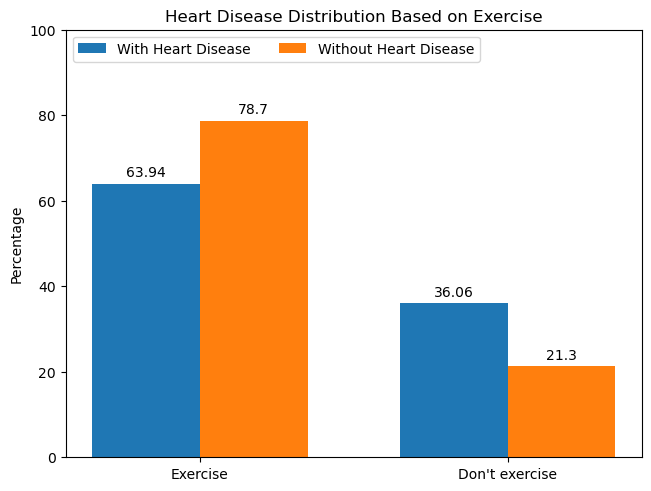

In [121]:
count_df_nd = df_no_disease.groupby('Exercise').size()
count_df_yd = df_yes_disease.groupby('Exercise').size()
exercise_T_y_hd = round(count_df_yd['Yes']/(count_df_yd['Yes'] + count_df_yd['No']) * 100, 2)
exercise_F_y_hd = round(count_df_yd['No']/(count_df_yd['Yes'] + count_df_yd['No']) * 100, 2)

exercise_T_n_hd = round(count_df_nd['Yes']/(count_df_nd['Yes'] + count_df_nd['No']) * 100, 2)
exercise_F_n_hd = round(count_df_nd['No']/(count_df_nd['Yes'] + count_df_nd['No']) * 100, 2)

exercise = ("Exercise", "Don't exercise")
counts = {
    'With Heart Disease': (exercise_T_y_hd, exercise_F_y_hd),
    'Without Heart Disease' : (exercise_T_n_hd, exercise_F_n_hd),
}
x = np.arange(len(exercise))
width = 0.35
multiplier = 0
fig, ax = plt.subplots(layout = 'constrained')

for attribute, measurement in counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label = attribute)
    ax.bar_label(rects, padding = 3)
    multiplier += 1

ax.set_ylabel('Percentage')
ax.set_title('Heart Disease Distribution Based on Exercise')
ax.set_xticks(x + width/2, exercise)
ax.legend(loc = 'upper left', ncols = 2)
ax.set_ylim(0, 100)

plt.show()

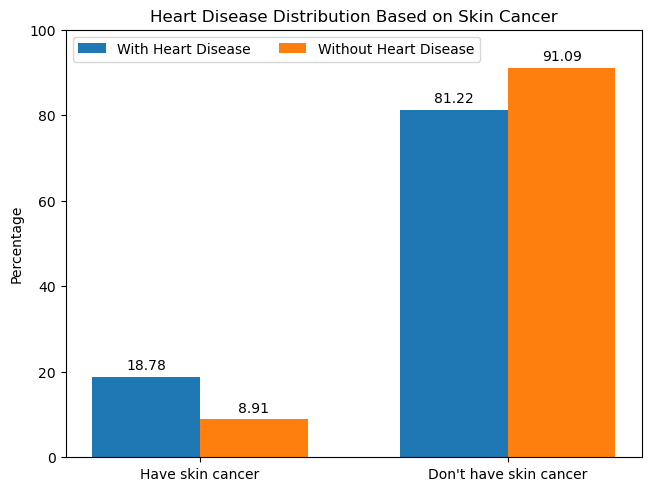

In [122]:
count_df_nd = df_no_disease.groupby('Skin_Cancer').size()
count_df_yd = df_yes_disease.groupby('Skin_Cancer').size()
skin_cancer_T_y_hd = round(count_df_yd['Yes']/(count_df_yd['Yes'] + count_df_yd['No']) * 100, 2)
skin_cancer_F_y_hd = round(count_df_yd['No']/(count_df_yd['Yes'] + count_df_yd['No']) * 100, 2)

skin_cancer_T_n_hd = round(count_df_nd['Yes']/(count_df_nd['Yes'] + count_df_nd['No']) * 100, 2)
skin_cancer_F_n_hd = round(count_df_nd['No']/(count_df_nd['Yes'] + count_df_nd['No']) * 100, 2)

skin_cancer = ("Have skin cancer", "Don't have skin cancer")
counts = {
    'With Heart Disease': (skin_cancer_T_y_hd, skin_cancer_F_y_hd),
    'Without Heart Disease' : (skin_cancer_T_n_hd, skin_cancer_F_n_hd),
}
x = np.arange(len(skin_cancer))
width = 0.35
multiplier = 0
fig, ax = plt.subplots(layout = 'constrained')

for attribute, measurement in counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label = attribute)
    ax.bar_label(rects, padding = 3)
    multiplier += 1

ax.set_ylabel('Percentage')
ax.set_title('Heart Disease Distribution Based on Skin Cancer')
ax.set_xticks(x + width/2, skin_cancer)
ax.legend(loc = 'upper left', ncols = 2)
ax.set_ylim(0, 100)

plt.show()

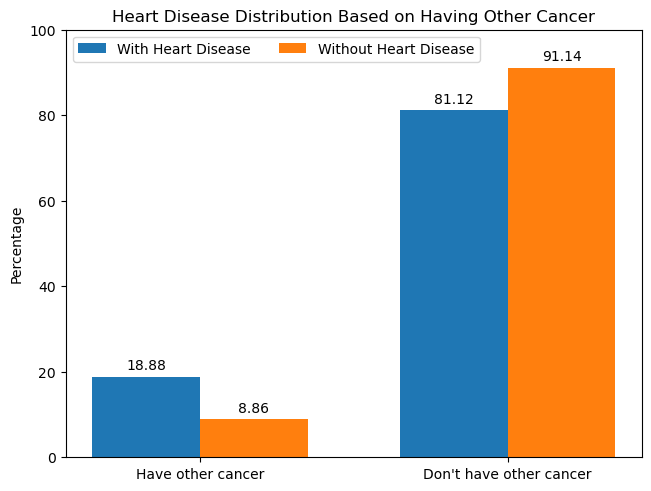

In [123]:
count_df_nd = df_no_disease.groupby('Other_Cancer').size()
count_df_yd = df_yes_disease.groupby('Other_Cancer').size()
other_cancer_T_y_hd = round(count_df_yd['Yes']/(count_df_yd['Yes'] + count_df_yd['No']) * 100, 2)
other_cancer_F_y_hd = round(count_df_yd['No']/(count_df_yd['Yes'] + count_df_yd['No']) * 100, 2)

other_cancer_T_n_hd = round(count_df_nd['Yes']/(count_df_nd['Yes'] + count_df_nd['No']) * 100, 2)
other_cancer_F_n_hd = round(count_df_nd['No']/(count_df_nd['Yes'] + count_df_nd['No']) * 100, 2)

other_cancer = ("Have other cancer", "Don't have other cancer")
counts = {
    'With Heart Disease': (other_cancer_T_y_hd, other_cancer_F_y_hd),
    'Without Heart Disease' : (other_cancer_T_n_hd, other_cancer_F_n_hd),
}
x = np.arange(len(other_cancer))
width = 0.35
multiplier = 0
fig, ax = plt.subplots(layout = 'constrained')

for attribute, measurement in counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label = attribute)
    ax.bar_label(rects, padding = 3)
    multiplier += 1

ax.set_ylabel('Percentage')
ax.set_title('Heart Disease Distribution Based on Having Other Cancer')
ax.set_xticks(x + width/2, other_cancer)
ax.legend(loc = 'upper left', ncols = 2)
ax.set_ylim(0, 100)

plt.show()

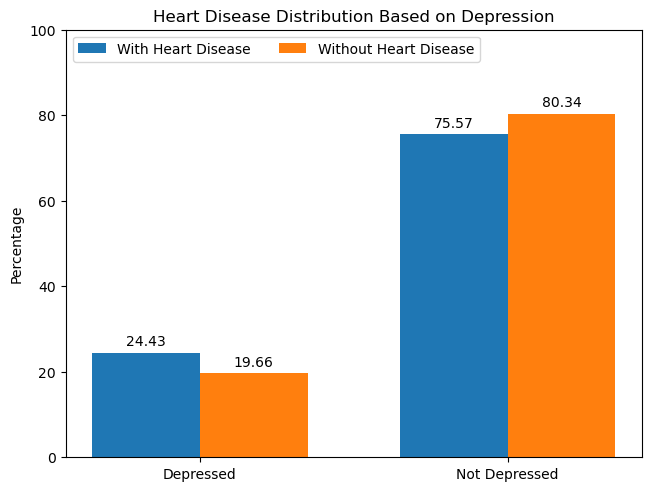

In [124]:
count_df_nd = df_no_disease.groupby('Depression').size()
count_df_yd = df_yes_disease.groupby('Depression').size()
depression_T_y_hd = round(count_df_yd['Yes']/(count_df_yd['Yes'] + count_df_yd['No']) * 100, 2)
depression_F_y_hd = round(count_df_yd['No']/(count_df_yd['Yes'] + count_df_yd['No']) * 100, 2)

depression_T_n_hd = round(count_df_nd['Yes']/(count_df_nd['Yes'] + count_df_nd['No']) * 100, 2)
depression_F_n_hd = round(count_df_nd['No']/(count_df_nd['Yes'] + count_df_nd['No']) * 100, 2)

depression = ("Depressed", "Not Depressed")
counts = {
    'With Heart Disease': (depression_T_y_hd, depression_F_y_hd),
    'Without Heart Disease' : (depression_T_n_hd, depression_F_n_hd),
}
x = np.arange(len(depression))
width = 0.35
multiplier = 0
fig, ax = plt.subplots(layout = 'constrained')

for attribute, measurement in counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label = attribute)
    ax.bar_label(rects, padding = 3)
    multiplier += 1

ax.set_ylabel('Percentage')
ax.set_title('Heart Disease Distribution Based on Depression')
ax.set_xticks(x + width/2, depression)
ax.legend(loc = 'upper left', ncols = 2)
ax.set_ylim(0, 100)

plt.show()

Text(0.5, 0.98, 'Diabetes')

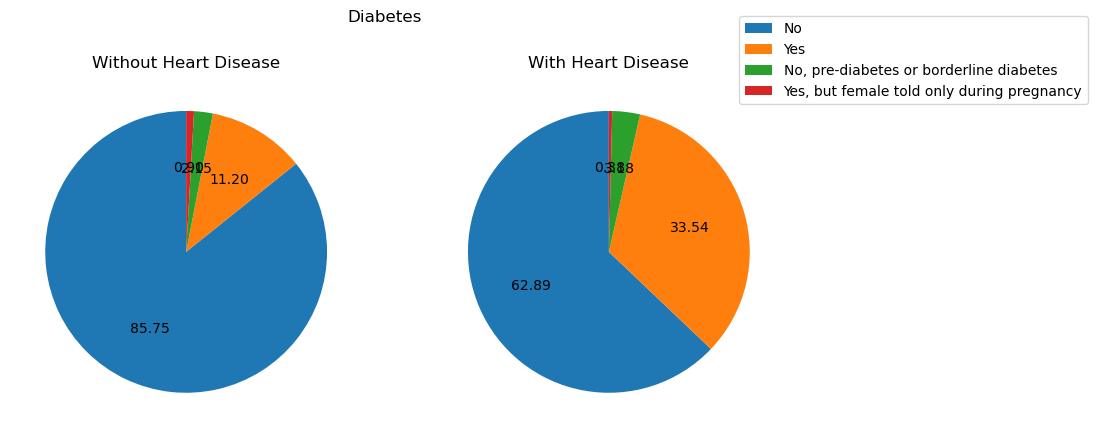

In [125]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
labels = df_no_disease['Diabetes'].value_counts().index.tolist()

axs[0].pie(df_no_disease['Diabetes'].value_counts(), 
           labels = None,
           autopct='%.2f', 
           startangle = 90)
axs[0].set_title('Without Heart Disease')


axs[1].pie(df_yes_disease['Diabetes'].value_counts(), 
           labels = None,
           autopct='%.2f', 
           startangle = 90)
axs[1].set_title('With Heart Disease')

plt.legend(labels, loc='best', bbox_to_anchor=(0.85, 0.9))

plt.suptitle('Diabetes')

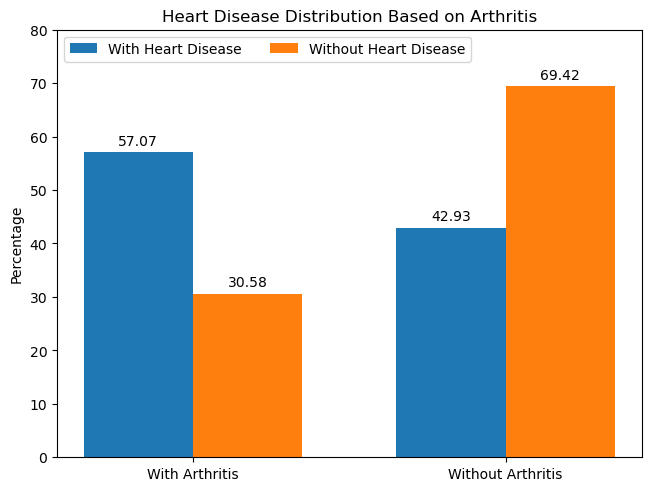

In [127]:
count_df_nd = df_no_disease.groupby('Arthritis').size()
count_df_yd = df_yes_disease.groupby('Arthritis').size()
arthritis_T_y_hd = round(count_df_yd['Yes']/(count_df_yd['Yes'] + count_df_yd['No']) * 100, 2)
arthritis_F_y_hd = round(count_df_yd['No']/(count_df_yd['Yes'] + count_df_yd['No']) * 100, 2)

arthritis_T_n_hd = round(count_df_nd['Yes']/(count_df_nd['Yes'] + count_df_nd['No']) * 100, 2)
arthritis_Y_n_hd = round(count_df_nd['No']/(count_df_nd['Yes'] + count_df_nd['No']) * 100, 2)

arthritis = ("With Arthritis", "Without Arthritis")
counts = {
    'With Heart Disease': (arthritis_T_y_hd, arthritis_F_y_hd ),
    'Without Heart Disease' : (arthritis_T_n_hd, arthritis_Y_n_hd),
}
x = np.arange(len(arthritis))
width = 0.35
multiplier = 0
fig, ax = plt.subplots(layout = 'constrained')

for attribute, measurement in counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label = attribute)
    ax.bar_label(rects, padding = 3)
    multiplier += 1

ax.set_ylabel('Percentage')
ax.set_title('Heart Disease Distribution Based on Arthritis')
ax.set_xticks(x + width/2, arthritis)
ax.legend(loc = 'upper left', ncols = 2)
ax.set_ylim(0, 80)

plt.show()

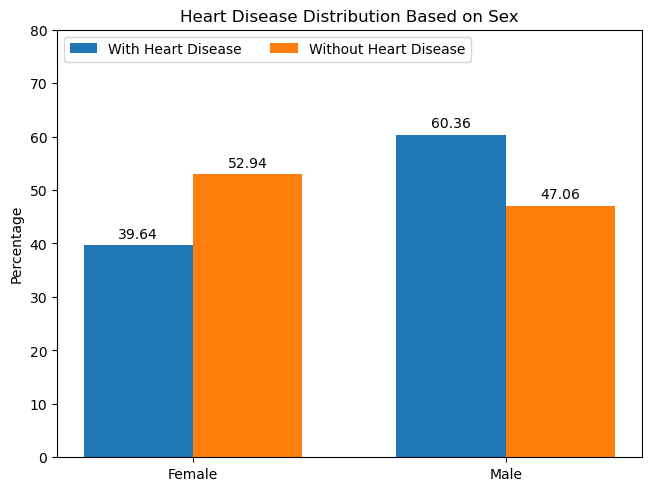

In [128]:
count_df_nd = df_no_disease.groupby('Sex').size()
count_df_yd = df_yes_disease.groupby('Sex').size()
female_y_hd = round(count_df_yd['Female']/(count_df_yd['Female'] + count_df_yd['Male']) * 100, 2)
male_y_hd = round(count_df_yd['Male']/(count_df_yd['Female'] + count_df_yd['Male']) * 100, 2)

female_n_hd = round(count_df_nd['Female']/(count_df_nd['Female'] + count_df_nd['Male']) * 100, 2)
male_n_hd = round(count_df_nd['Male']/(count_df_nd['Female'] + count_df_nd['Male']) * 100, 2)

sex = ("Female", "Male")
counts = {
    'With Heart Disease': (female_y_hd, male_y_hd ),
    'Without Heart Disease' : (female_n_hd, male_n_hd),
}
x = np.arange(len(sex))
width = 0.35
multiplier = 0
fig, ax = plt.subplots(layout = 'constrained')

for attribute, measurement in counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label = attribute)
    ax.bar_label(rects, padding = 3)
    multiplier += 1

ax.set_ylabel('Percentage')
ax.set_title('Heart Disease Distribution Based on Sex')
ax.set_xticks(x + width/2, sex)
ax.legend(loc = 'upper left', ncols = 2)
ax.set_ylim(0, 80)

plt.show()

Text(0.5, 0.98, 'Age Category')

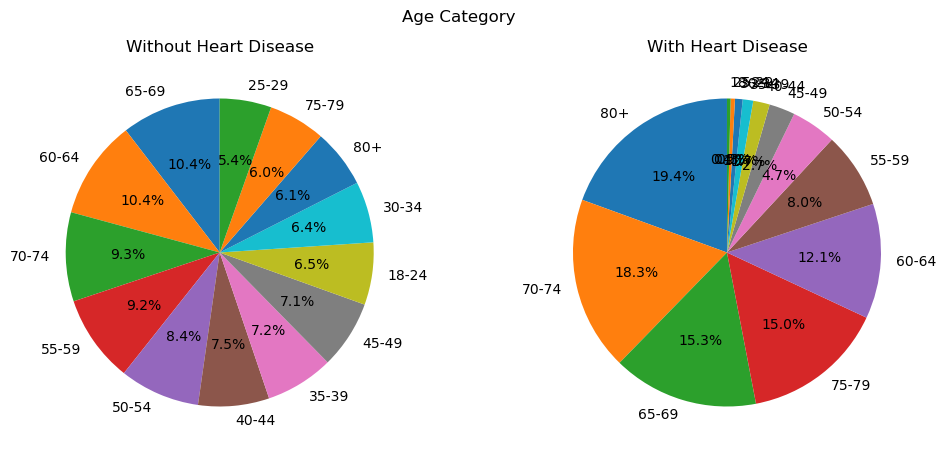

In [161]:
fig, axs = plt.subplots(1, 2, figsize = (12, 5))
labels_n_hd = df_no_disease['Age_Category'].value_counts().index.tolist()
labels_y_hd = df_yes_disease['Age_Category'].value_counts().index.tolist()

axs[0].pie(df_no_disease['Age_Category'].value_counts(), 
           labels = df_no_disease['Age_Category'].value_counts().index.tolist(),
           autopct='%1.1f%%', 
           startangle = 90)
axs[0].set_title('Without Heart Disease')


axs[1].pie(df_yes_disease['Age_Category'].value_counts(), 
           labels =  df_yes_disease['Age_Category'].value_counts().index.tolist(),
           autopct='%1.1f%%', 
           startangle = 90)
axs[1].set_title('With Heart Disease')


plt.suptitle('Age Category')

In [156]:
labels_n_hd = df_no_disease['Age_Category'].value_counts().index.tolist()
labels_y_hd = df_yes_disease['Age_Category'].value_counts().index.tolist()
labels_n_hd, labels_y_hd

(['65-69',
  '60-64',
  '70-74',
  '55-59',
  '50-54',
  '40-44',
  '35-39',
  '45-49',
  '18-24',
  '30-34',
  '80+',
  '75-79',
  '25-29'],
 ['80+',
  '70-74',
  '65-69',
  '75-79',
  '60-64',
  '55-59',
  '50-54',
  '45-49',
  '40-44',
  '35-39',
  '30-34',
  '25-29',
  '18-24'])

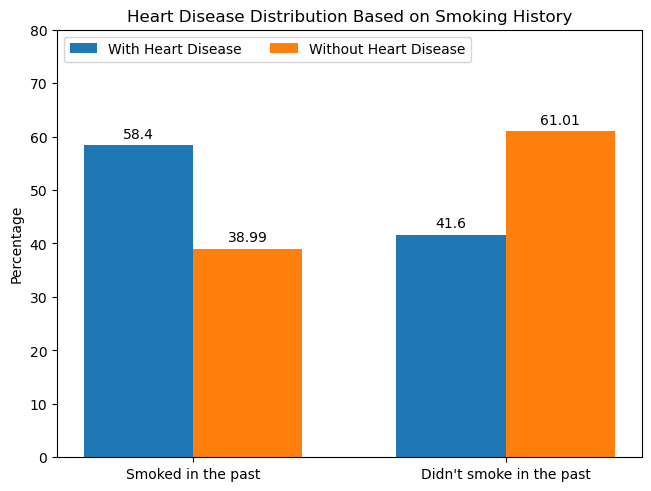

In [134]:
count_df_nd = df_no_disease.groupby('Smoking_History').size()
count_df_yd = df_yes_disease.groupby('Smoking_History').size()
smokers_T_y_hd = round(count_df_yd['Yes']/(count_df_yd['Yes'] + count_df_yd['No']) * 100, 2)
smokers_F_y_hd = round(count_df_yd['No']/(count_df_yd['Yes'] + count_df_yd['No']) * 100, 2)

smokers_T_n_hd = round(count_df_nd['Yes']/(count_df_nd['Yes'] + count_df_nd['No']) * 100, 2)
smokers_F_n_hd = round(count_df_nd['No']/(count_df_nd['Yes'] + count_df_nd['No']) * 100, 2)

smoking = ("Smoked in the past", "Didn't smoke in the past")
counts = {
    'With Heart Disease': (smokers_T_y_hd, smokers_F_y_hd ),
    'Without Heart Disease' : (smokers_T_n_hd, smokers_F_n_hd),
}
x = np.arange(len(smoking))
width = 0.35
multiplier = 0
fig, ax = plt.subplots(layout = 'constrained')

for attribute, measurement in counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label = attribute)
    ax.bar_label(rects, padding = 3)
    multiplier += 1

ax.set_ylabel('Percentage')
ax.set_title('Heart Disease Distribution Based on Smoking History')
ax.set_xticks(x + width/2, smoking)
ax.legend(loc = 'upper left', ncols = 2)
ax.set_ylim(0, 80)

plt.show()

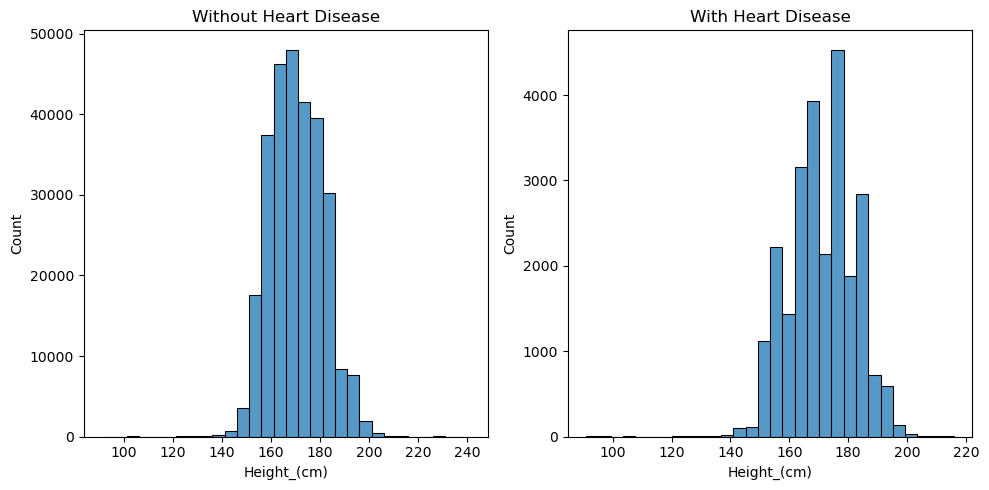

In [18]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

sb.histplot(data = df_no_disease, x = "Height_(cm)", ax = axs[0], bins = 30)
axs[0].set_title("Without Heart Disease")

sb.histplot(data = df_yes_disease, x = "Height_(cm)", ax = axs[1], bins = 30)
axs[1].set_title("With Heart Disease")

plt.tight_layout()

plt.show()

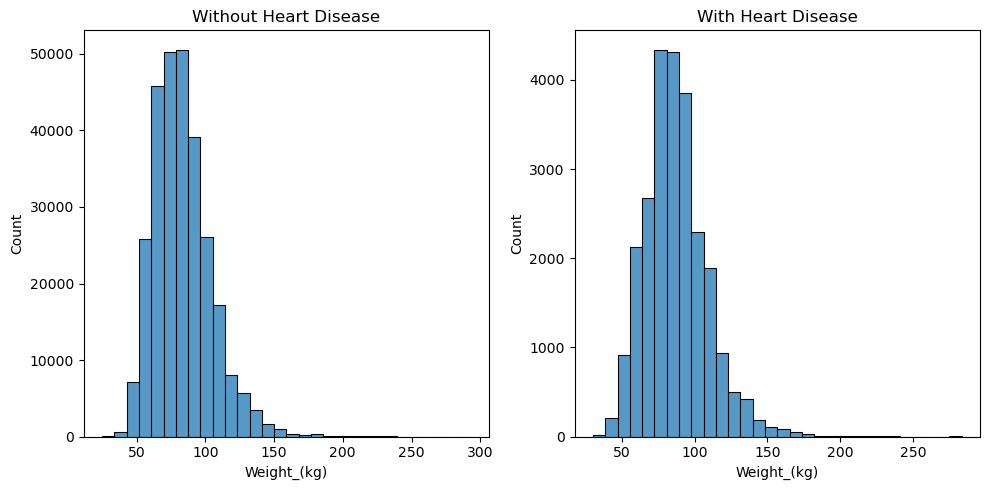

In [19]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

sb.histplot(data = df_no_disease, x = "Weight_(kg)", ax = axs[0], bins = 30)
axs[0].set_title("Without Heart Disease")

sb.histplot(data = df_yes_disease, x = "Weight_(kg)", ax = axs[1], bins = 30)
axs[1].set_title("With Heart Disease")

plt.tight_layout()

plt.show()

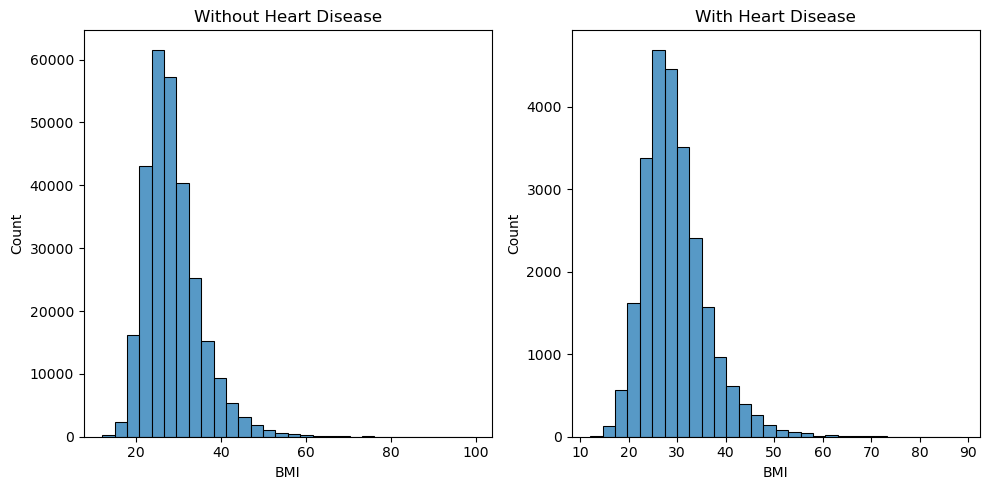

In [20]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

sb.histplot(data = df_no_disease, x = "BMI", ax = axs[0], bins = 30)
axs[0].set_title("Without Heart Disease")

sb.histplot(data = df_yes_disease, x = "BMI", ax = axs[1], bins = 30)
axs[1].set_title("With Heart Disease")

plt.tight_layout()

plt.show()

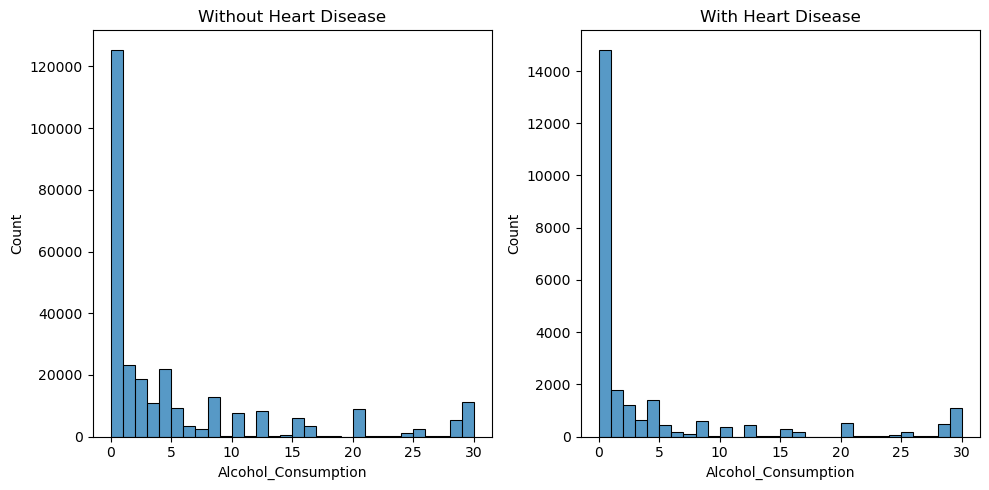

In [21]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

sb.histplot(data = df_no_disease, x = "Alcohol_Consumption", ax = axs[0], bins = 30)
axs[0].set_title("Without Heart Disease")

sb.histplot(data = df_yes_disease, x = "Alcohol_Consumption", ax = axs[1], bins = 30)
axs[1].set_title("With Heart Disease")

plt.tight_layout()

plt.show()

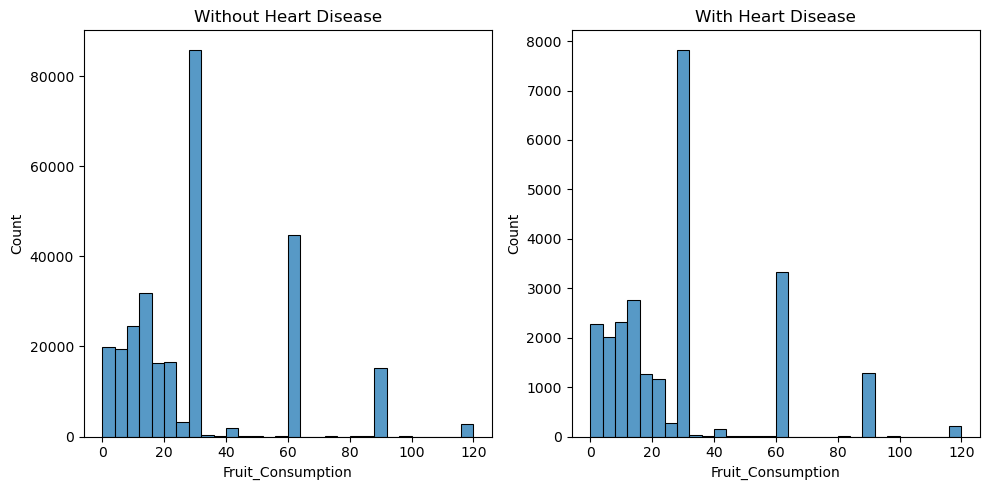

In [22]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

sb.histplot(data = df_no_disease, x = "Fruit_Consumption", ax = axs[0], bins = 30)
axs[0].set_title("Without Heart Disease")

sb.histplot(data = df_yes_disease, x = "Fruit_Consumption", ax = axs[1], bins = 30)
axs[1].set_title("With Heart Disease")

plt.tight_layout()

plt.show()

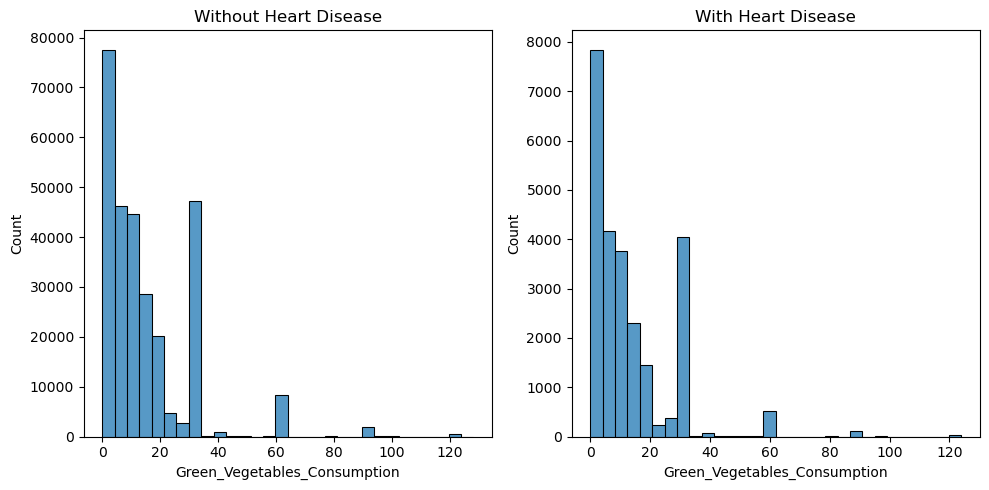

In [23]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

sb.histplot(data = df_no_disease, x = "Green_Vegetables_Consumption", ax = axs[0], bins = 30)
axs[0].set_title("Without Heart Disease")

sb.histplot(data = df_yes_disease, x = "Green_Vegetables_Consumption", ax = axs[1], bins = 30)
axs[1].set_title("With Heart Disease")

plt.tight_layout()

plt.show()

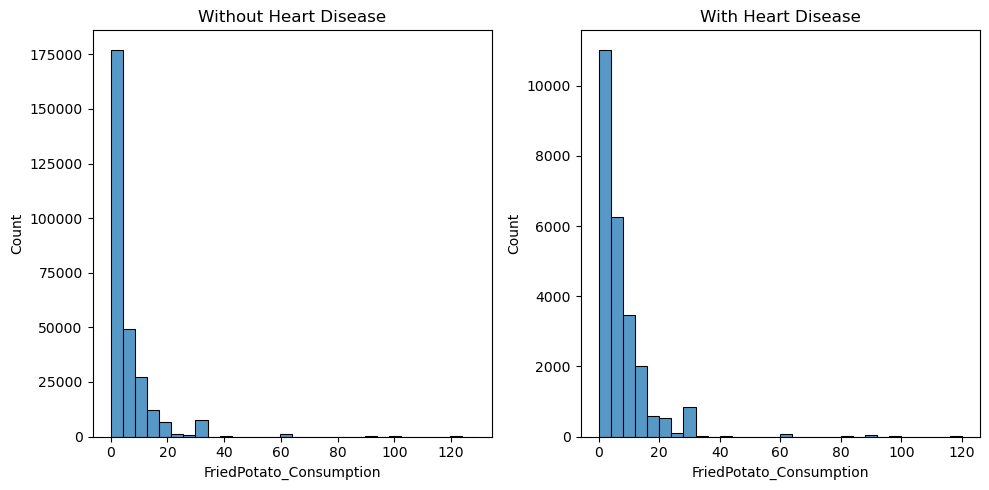

In [24]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

sb.histplot(data = df_no_disease, x = "FriedPotato_Consumption", ax = axs[0], bins = 30)
axs[0].set_title("Without Heart Disease")

sb.histplot(data = df_yes_disease, x = "FriedPotato_Consumption", ax = axs[1], bins = 30)
axs[1].set_title("With Heart Disease")

plt.tight_layout()

plt.show()

# Bivariate Analysis

In [25]:
def eda_bivariate_numerical(data,column,target,color,
                    figsize=(12,6),
                    # save=True,
                    val=0,
                    target_type = 'Numerical'):

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    cmap = sb.color_palette(color)
    val = val

    for i in range(1):
        for j in range(2):
            if j==0:
                    sb.histplot(data = data,x=data[column],hue=target,
                                bins=50,kde=True,palette=color,ax=axes[j])
                    axes[j].set(xlabel=None)
                    axes[j].grid(False)
            elif j==1:
                sb.boxplot(data = data,x=data[column],y = target, ax=axes[j], palette=color,orient='h',
                )
                axes[j].set(xlabel=None)
                axes[j].grid(False)
                val += 1
                plt.tight_layout()
            if target_type == 'Numerical':
                plt.suptitle(column)
            else:
                plt.suptitle(f'{column} vs. {target}')
    plt.show()

## Chi2 test

In [78]:
from scipy.stats.contingency import crosstab, chi2_contingency
res = crosstab(df.Heart_Disease, df.Sex)
print('## Chi2test for Heart Disease and Sex ##')
chi2_contingency(res[1])

## Chi2test for Heart Disease and Sex ##


Chi2ContingencyResult(statistic=1627.1191844519758, pvalue=0.0, dof=1, expected_freq=array([[147244.07347161, 136638.92652839],
       [ 12951.92652839,  12019.07347161]]))

In [79]:
from scipy.stats.contingency import crosstab, chi2_contingency
res = crosstab(df.Heart_Disease, df.Age_Category)
print('## Chi2test for Heart Disease and Age Category ##')
chi2_contingency(res[1])

## Chi2test for Heart Disease and Age Category ##


Chi2ContingencyResult(statistic=18035.930858650143, pvalue=0.0, dof=12, expected_freq=array([[17170.63182928, 14241.3023694 , 16938.08700551, 18939.99461882,
        19849.03347536, 19272.7267382 , 23067.89502807, 25785.8201027 ,
        29796.98852532, 30730.8444184 , 28588.30693143, 19030.99041942,
        20470.37853808],
       [ 1510.36817072,  1252.6976306 ,  1489.91299449,  1666.00538118,
         1745.96652464,  1695.2732618 ,  2029.10497193,  2268.1798973 ,
         2621.01147468,  2703.1555816 ,  2514.69306857,  1674.00958058,
         1800.62146192]]))

In [82]:
from scipy.stats.contingency import crosstab, chi2_contingency
res = crosstab(df.Heart_Disease, df.Diabetes)
print('## Chi2test for Heart Disease and Diabetes ##')
chi2_contingency(res[1])

## Chi2test for Heart Disease and Diabetes ##


CrosstabResult(elements=(array(['No', 'Yes'], dtype=object), array(['No', 'No, pre-diabetes or borderline diabetes', 'Yes',
       'Yes, but female told only during pregnancy'], dtype=object)), count=array([[243436,   6102,  31795,   2550],
       [ 15705,    794,   8376,     96]]))

In [122]:
pd.crosstab([df.Heart_Disease], [df.Sex], margins = True)

Sex,Female,Male,All
Heart_Disease,,,
No,150298,133585,283883
Yes,9898,15073,24971
All,160196,148658,308854


In [81]:
from scipy.stats.contingency import crosstab, chi2_contingency
res = crosstab(df.Heart_Disease, df.Skin_Cancer)
print('## Chi2test for Heart Disease and Skin Cancer ##')
chi2_contingency(res[1])

## Chi2test for Heart Disease and Skin Cancer ##


Chi2ContingencyResult(statistic=2547.9855141817616, pvalue=0.0, dof=1, expected_freq=array([[256314.02986524,  27568.97013476],
       [ 22545.97013476,   2425.02986524]]))

In [217]:
from scipy.stats.contingency import crosstab, chi2_contingency
res = crosstab(df.Heart_Disease, df.Other_Cancer)
print('## Chi2test for Heart Disease and Other Cancer ##')
chi2_contingency(res[1])

## Chi2test for Heart Disease and Skin Cancer ##


Chi2ContingencyResult(statistic=2635.037602089007, pvalue=0.0, dof=1, expected_freq=array([[256420.65120737,  27462.34879263],
       [ 22555.34879263,   2415.65120737]]))

In [218]:
from scipy.stats.contingency import crosstab, chi2_contingency
res = crosstab(df.Heart_Disease, df.Arthritis)
print('## Chi2test for Heart Disease and Arthritis  ##')
chi2_contingency(res[1])

## Chi2test for Heart Disease and Arthritis  ##


Chi2ContingencyResult(statistic=7315.345489535121, pvalue=0.0, dof=1, expected_freq=array([[190983.64077849,  92899.35922151],
       [ 16799.35922151,   8171.64077849]]))

In [220]:
from scipy.stats.contingency import crosstab, chi2_contingency
res = crosstab(df.Heart_Disease, df.Smoking_History)
print('## Chi2test for Heart Disease and Smoking_History  ##')
chi2_contingency(res[1])

## Chi2test for Heart Disease and Smoking_History  ##


Chi2ContingencyResult(statistic=3588.1356452730433, pvalue=0.0, dof=1, expected_freq=array([[168746.65689938, 115136.34310062],
       [ 14843.34310062,  10127.65689938]]))

In [221]:
from scipy.stats.contingency import crosstab, chi2_contingency
res = crosstab(df.Heart_Disease, df.Depression)
print('## Chi2test for Heart Disease and Depression  ##')
chi2_contingency(res[1])

## Chi2test for Heart Disease and Smoking_History  ##


Chi2ContingencyResult(statistic=326.4478398515398, pvalue=5.70775202680712e-73, dof=1, expected_freq=array([[226986.72673496,  56896.27326504],
       [ 19966.27326504,   5004.72673496]]))

In [222]:
from scipy.stats.contingency import crosstab, chi2_contingency
res = crosstab(df.Heart_Disease, df.Checkup)
print('## Chi2test for Heart Disease and Checkup  ##')
chi2_contingency(res[1])

## Chi2test for Heart Disease and Checkup  ##


Chi2ContingencyResult(statistic=2731.043538247254, pvalue=0.0, dof=4, expected_freq=array([[1.23359055e+04, 1.29324335e+03, 3.42043104e+04, 1.60318056e+04,
        2.20017735e+05],
       [1.08509455e+03, 1.13756652e+02, 3.00868962e+03, 1.41019440e+03,
        1.93532648e+04]]))

In [223]:
from scipy.stats.contingency import crosstab, chi2_contingency
res = crosstab(df.Heart_Disease, df.Exercise)
print('## Chi2test for Heart Disease and Exercise  ##')
chi2_contingency(res[1])

## Chi2test for Heart Disease and Checkup  ##


Chi2ContingencyResult(statistic=2866.154497542652, pvalue=0.0, dof=1, expected_freq=array([[ 63856.07328705, 220026.92671295],
       [  5616.92671295,  19354.07328705]]))

In [224]:
from scipy.stats.contingency import crosstab, chi2_contingency
res = crosstab(df.Heart_Disease, df.General_Health)
print('## Chi2test for Heart Disease and General_Health  ##')
chi2_contingency(res[1])

## Chi2test for Heart Disease and General_Health  ##


Chi2ContingencyResult(statistic=19234.33413703971, pvalue=0.0, dof=4, expected_freq=array([[ 51430.09118224,  32914.74363291,  87653.77301897,
         10414.8829965 , 101469.50916938],
       [  4523.90881776,   2895.25636709,   7710.22698103,
           916.1170035 ,   8925.49083062]]))

## Numerical variables

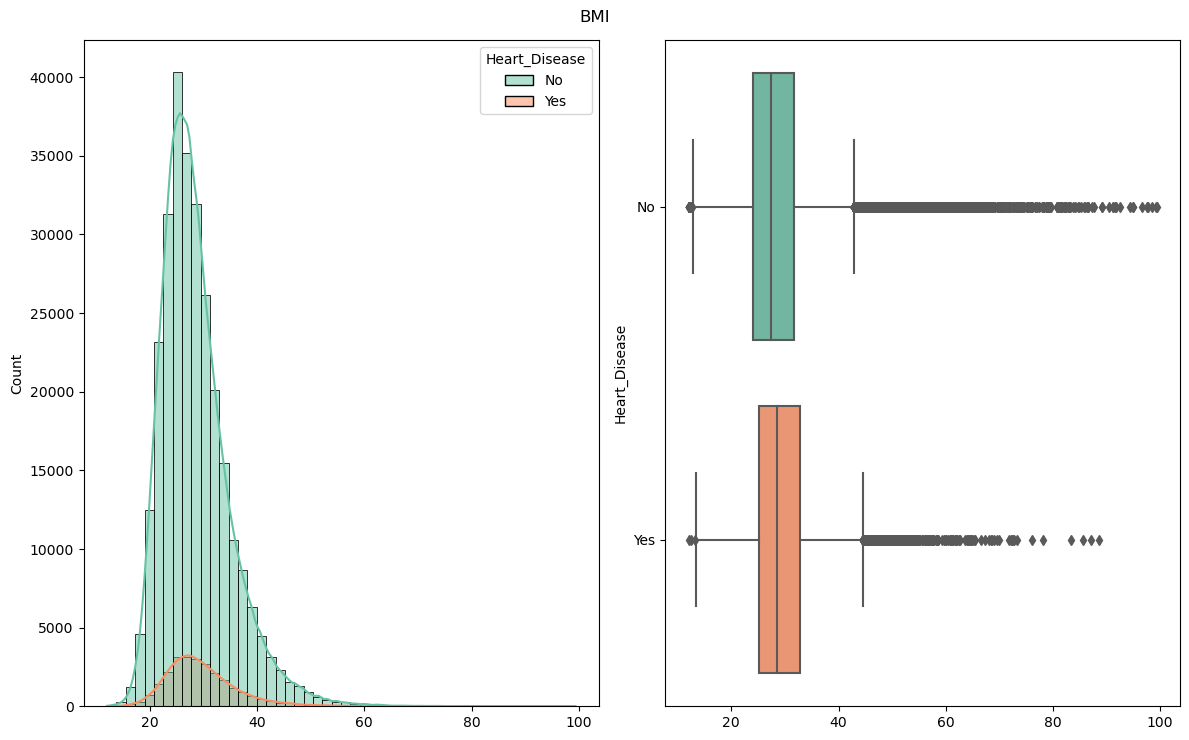

In [33]:
eda_bivariate_numerical(data = df, column = 'BMI', target = 'Heart_Disease', color = 'Set2', figsize = (12, 7.5), val=0)

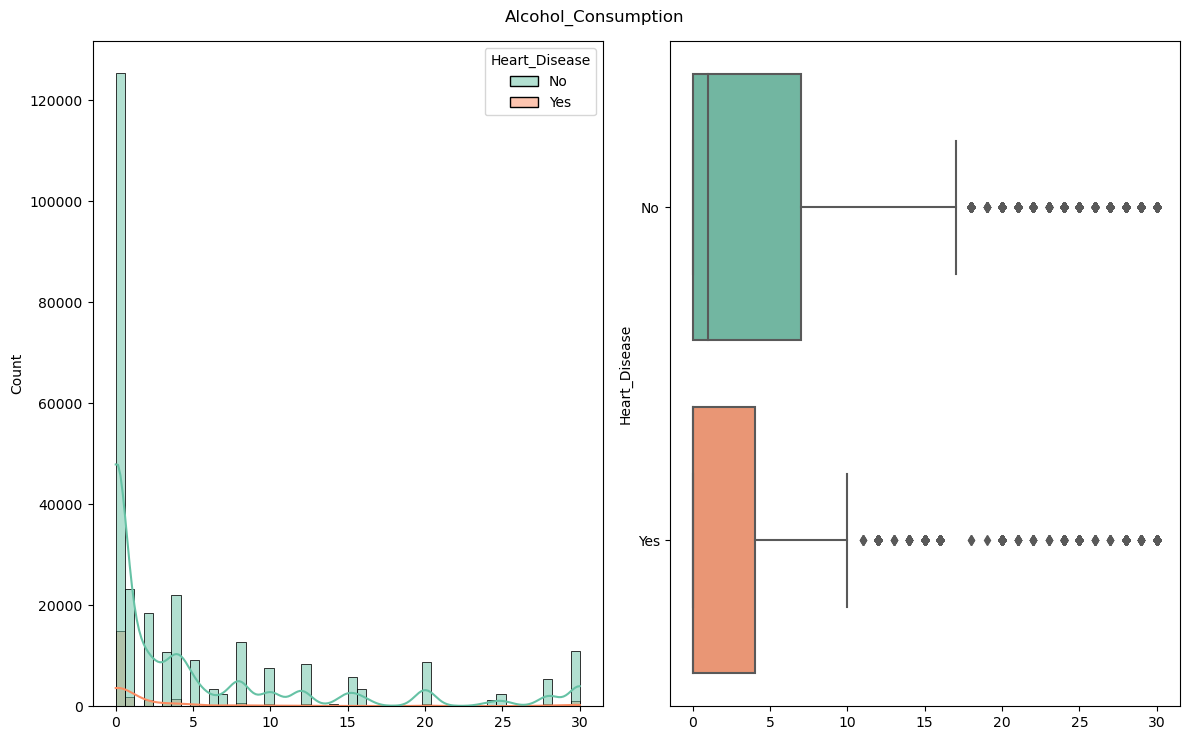

In [34]:
eda_bivariate_numerical(data = df, column = 'Alcohol_Consumption', target = 'Heart_Disease', color = 'Set2', figsize = (12, 7.5), val=0)

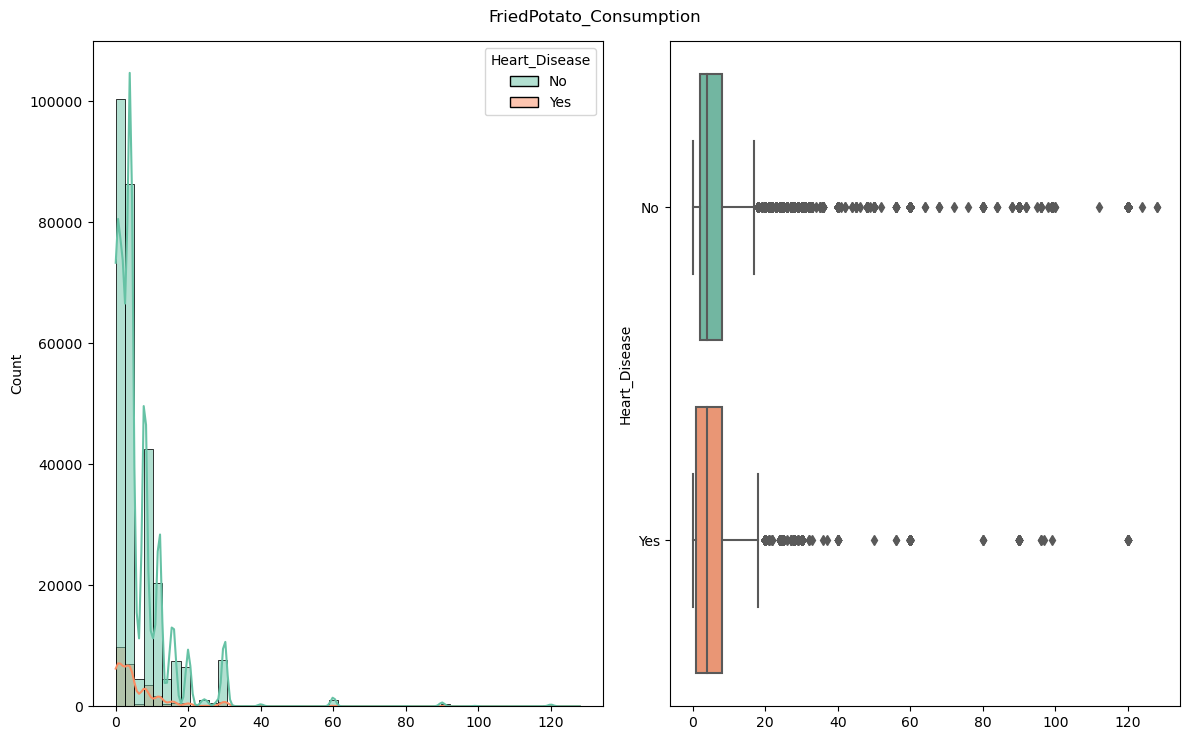

In [35]:
eda_bivariate_numerical(data = df, column = 'FriedPotato_Consumption', target = 'Heart_Disease', color = 'Set2', figsize = (12, 7.5), val=0)

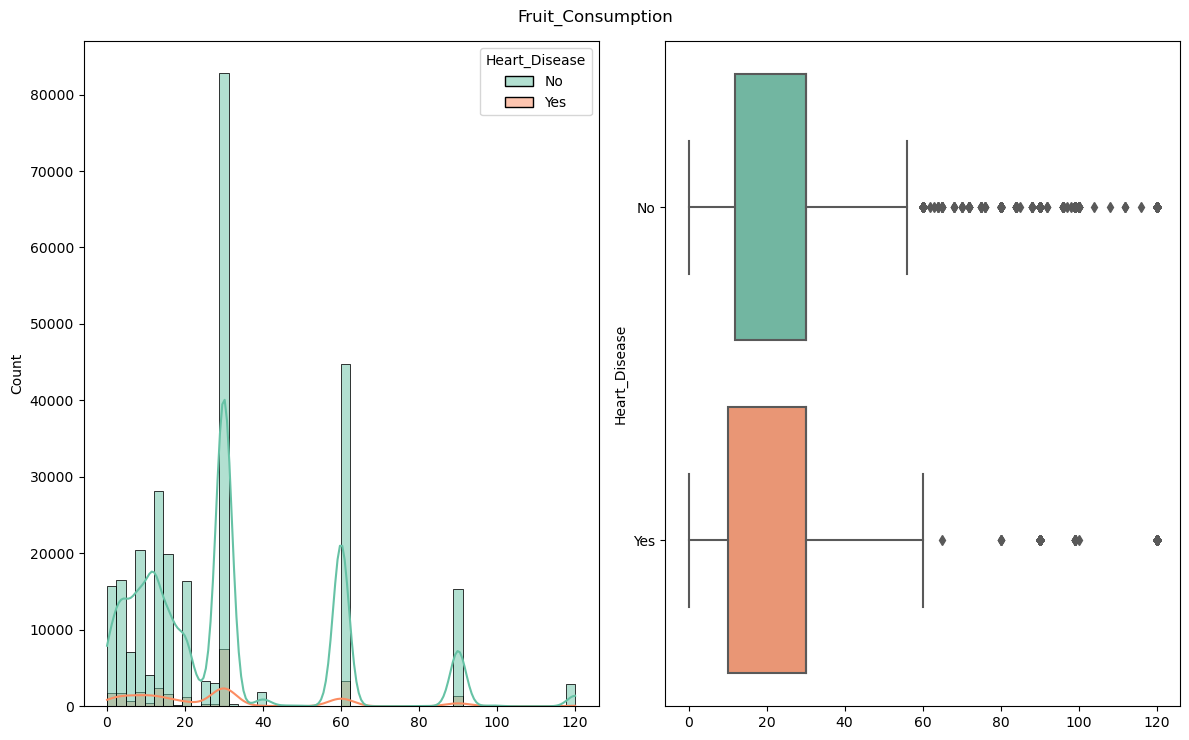

In [36]:
eda_bivariate_numerical(data = df, column = 'Fruit_Consumption', target = 'Heart_Disease', color = 'Set2', figsize = (12, 7.5), val=0)

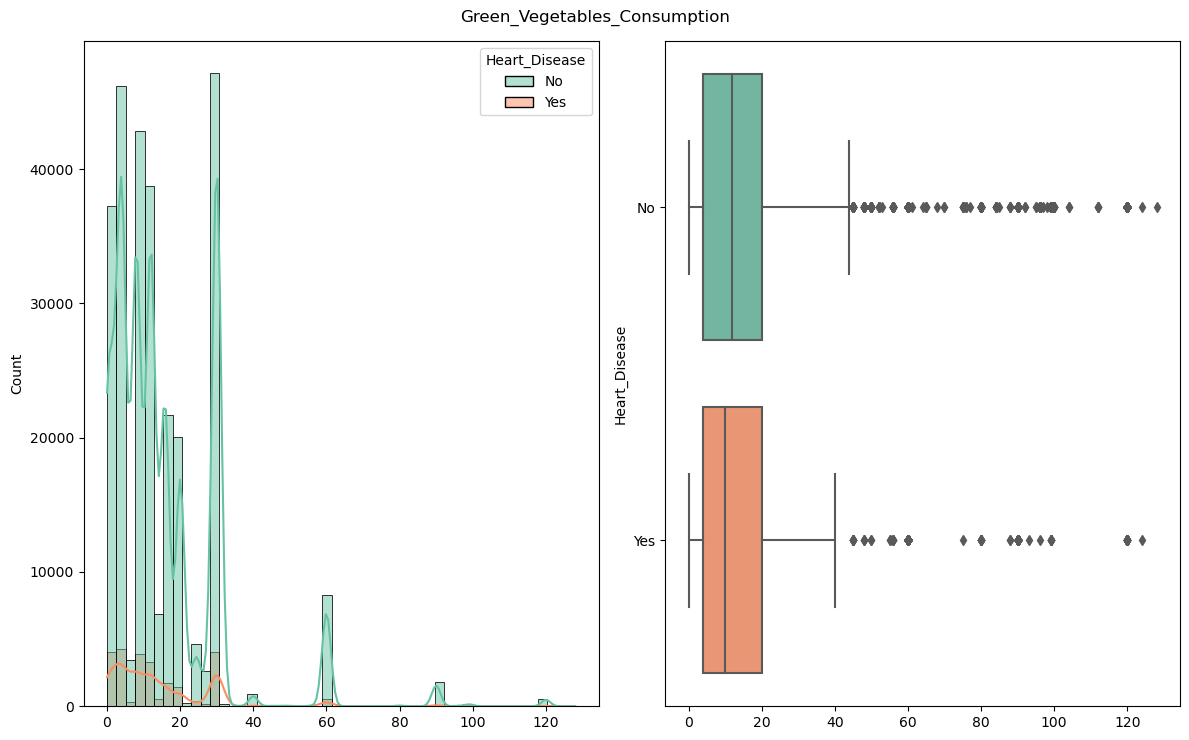

In [37]:
eda_bivariate_numerical(data = df, column = 'Green_Vegetables_Consumption', target = 'Heart_Disease', color = 'Set2', figsize = (12, 7.5), val=0)

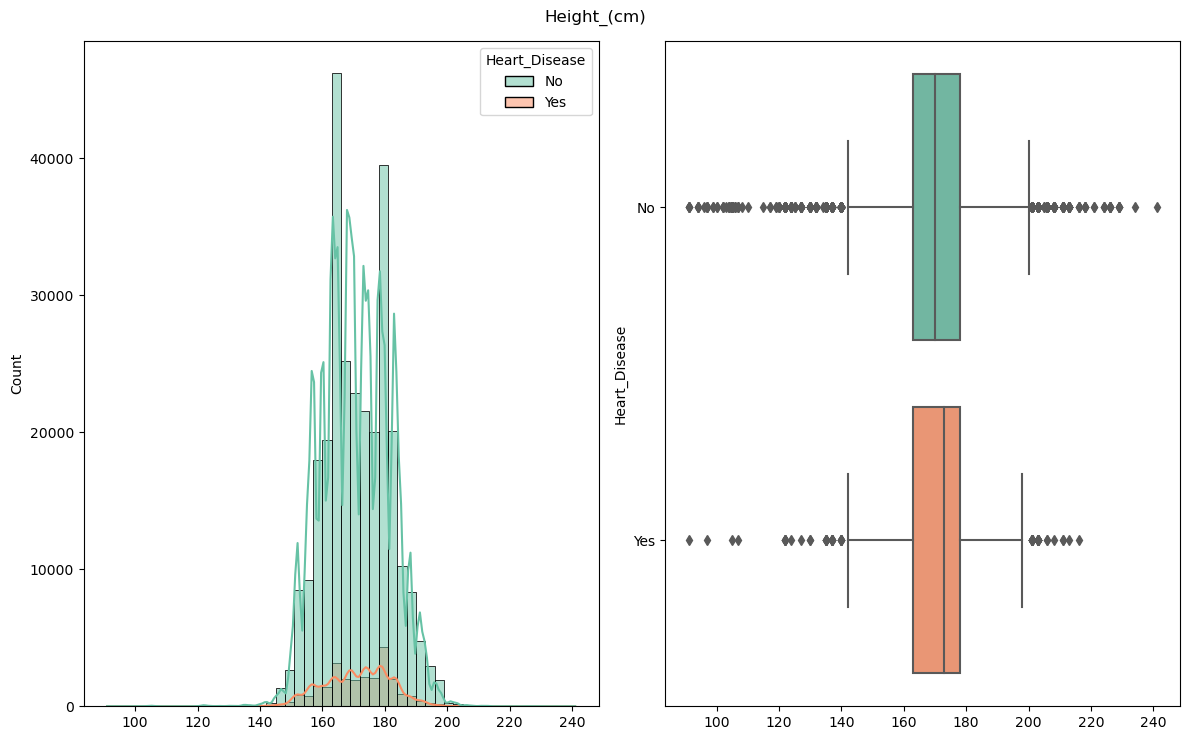

In [38]:
eda_bivariate_numerical(data = df, column = 'Height_(cm)', target = 'Heart_Disease', color = 'Set2', figsize = (12, 7.5), val=0)

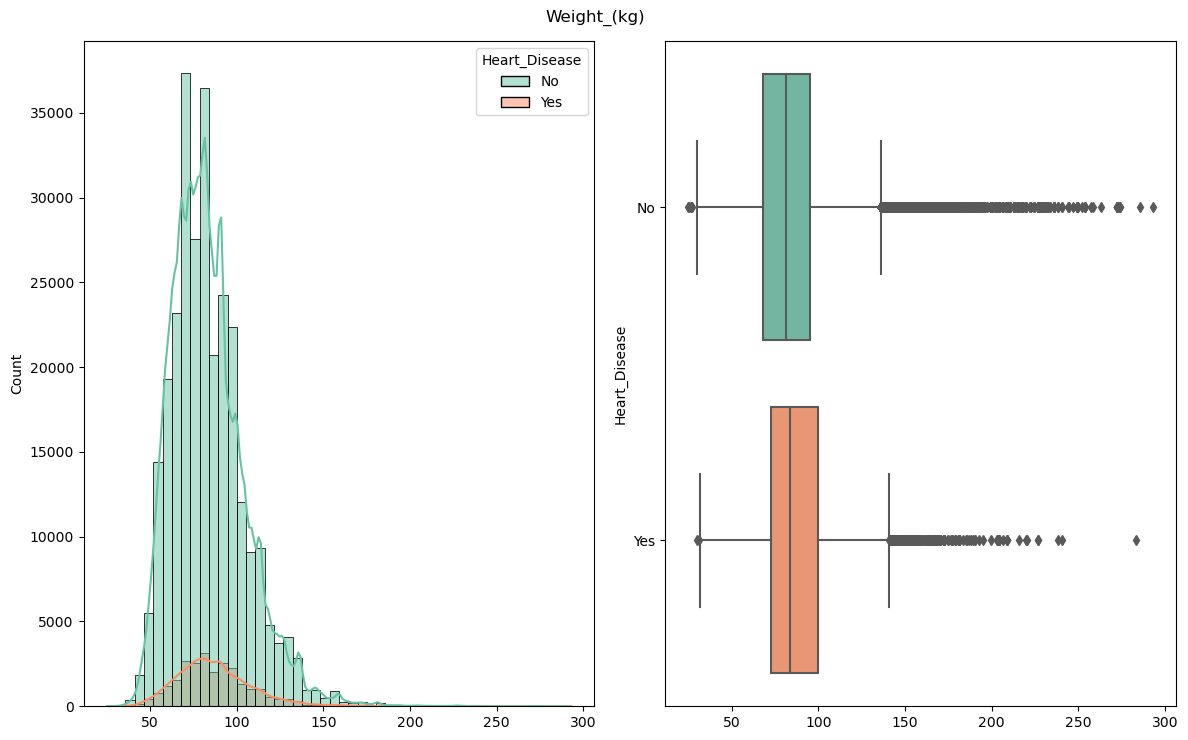

In [39]:
eda_bivariate_numerical(data = df, column = 'Weight_(kg)', target = 'Heart_Disease', color = 'Set2', figsize = (12, 7.5), val=0)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


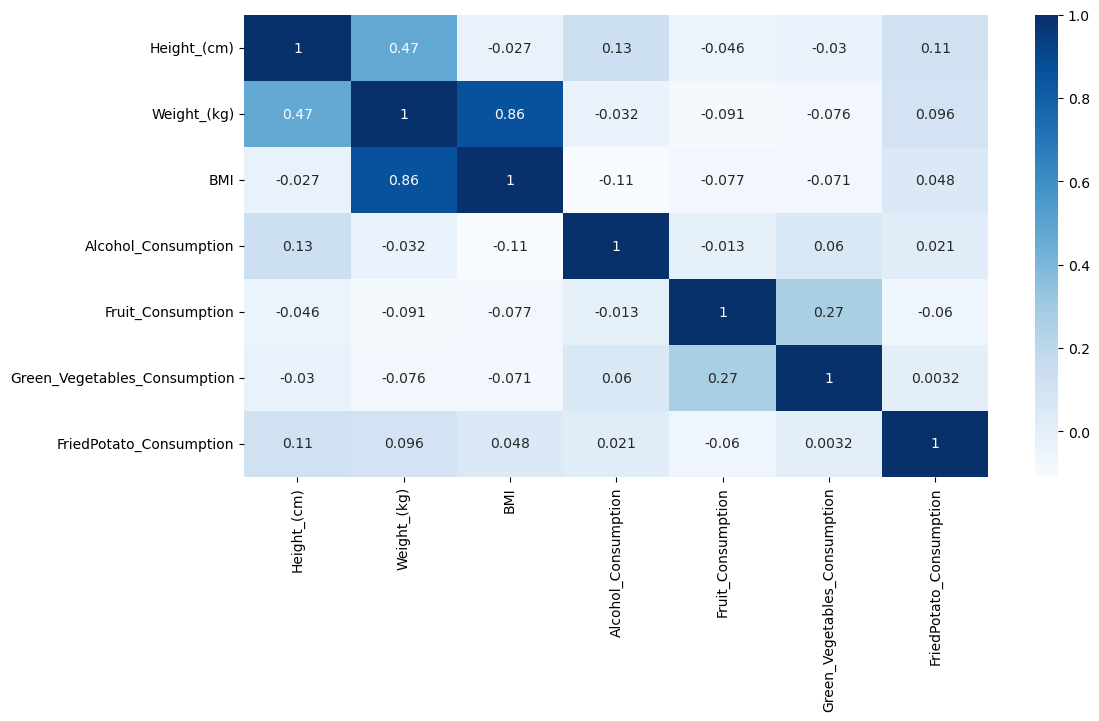

In [230]:
plt.figure(figsize = (12, 6))
sb.heatmap(df.corr(), annot = True, cmap = 'Blues')
plt.show()

# Preprocessing

In [165]:
df['Heart_Disease'] = df['Heart_Disease'].map({'No':0,'Yes':1})
print(df['Heart_Disease'].value_counts())

0    283883
1     24971
Name: Heart_Disease, dtype: int64


### Nominal

In [166]:
ed = pd.get_dummies(df['Exercise'], prefix = "exercise")
df = pd.concat([df, ed], axis = 1)
df.drop(['Exercise'], axis = 1, inplace = True)

In [167]:
scd = pd.get_dummies(df['Skin_Cancer'], prefix = "skin_cancer")
df = pd.concat([df, scd], axis = 1)
df.drop(['Skin_Cancer'], axis = 1, inplace = True)

In [168]:
ocd = pd.get_dummies(df['Other_Cancer'], prefix = "other_cancer")
df = pd.concat([df, ocd], axis = 1)
df.drop(['Other_Cancer'], axis = 1, inplace = True)

In [169]:
dd = pd.get_dummies(df['Depression'], prefix = "depression")
df = pd.concat([df, dd], axis = 1)
df.drop(['Depression'], axis = 1, inplace = True)

In [170]:
did = pd.get_dummies(df['Diabetes'], prefix = "diabetes")
df = pd.concat([df, did], axis = 1)
df.drop(['Diabetes'], axis = 1, inplace = True)

In [171]:
ad = pd.get_dummies(df['Arthritis'], prefix = "arthritis")
df = pd.concat([df, ad], axis = 1)
df.drop(['Arthritis'], axis = 1, inplace = True)

In [172]:
sed = pd.get_dummies(df['Sex'], prefix = "sex")
df = pd.concat([df, sed], axis = 1)
df.drop(['Sex'], axis = 1, inplace = True)

In [173]:
shd = pd.get_dummies(df['Smoking_History'], prefix = "smoking_history")
df = pd.concat([df, shd], axis = 1)
df.drop(['Smoking_History'], axis = 1, inplace = True)

### Ordinal

In [174]:
df['General_Health'].unique()

array(['Poor', 'Very Good', 'Good', 'Fair', 'Excellent'], dtype=object)

In [175]:
general_health = ['Poor', 'Fair','Good', 'Very Good', 'Excellent']

In [176]:
enc = OrdinalEncoder(categories = [general_health])

In [177]:
enc.fit_transform(df[['General_Health']])

array([[0.],
       [3.],
       [3.],
       ...,
       [3.],
       [3.],
       [4.]])

In [178]:
df[['General_Health']] = enc.fit_transform(df[['General_Health']])

In [179]:
df['Checkup'].unique()

array(['Within the past 2 years', 'Within the past year',
       '5 or more years ago', 'Within the past 5 years', 'Never'],
      dtype=object)

In [180]:
checkup = ['Within the past year','Within the past 2 years','Within the past 5 years','5 or more years ago','Never']

In [181]:
enc = OrdinalEncoder(categories = [checkup])

In [182]:
enc.fit_transform(df[['Checkup']])

array([[1.],
       [0.],
       [0.],
       ...,
       [3.],
       [0.],
       [0.]])

In [183]:
df[['Checkup']] = enc.fit_transform(df[['Checkup']])

In [184]:
df['Age_Category'].unique()

array(['70-74', '60-64', '75-79', '80+', '65-69', '50-54', '45-49',
       '18-24', '30-34', '55-59', '35-39', '40-44', '25-29'], dtype=object)

In [185]:
enc = OrdinalEncoder()

In [186]:
df['Age_Category'] = enc.fit_transform(df[['Age_Category']])

In [187]:
df.head()

,General_Health,Checkup,Heart_Disease,Age_Category,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,...,diabetes_No,"diabetes_No, pre-diabetes or borderline diabetes",diabetes_Yes,"diabetes_Yes, but female told only during pregnancy",arthritis_No,arthritis_Yes,sex_Female,sex_Male,smoking_history_No,smoking_history_Yes
0,0.0,1.0,0,10.0,150.0,32.66,14.54,0.0,30.0,16.0,...,1,0,0,0,0,1,1,0,0,1
1,3.0,0.0,1,10.0,165.0,77.11,28.29,0.0,30.0,0.0,...,0,0,1,0,1,0,1,0,1,0
2,3.0,0.0,0,8.0,163.0,88.45,33.47,4.0,12.0,3.0,...,0,0,1,0,1,0,1,0,1,0
3,0.0,0.0,1,11.0,180.0,93.44,28.73,0.0,30.0,30.0,...,0,0,1,0,1,0,0,1,1,0
4,2.0,0.0,0,12.0,191.0,88.45,24.37,0.0,8.0,4.0,...,1,0,0,0,1,0,0,1,0,1


In [188]:
df.dtypes

General_Health                                         float64
Checkup                                                float64
Heart_Disease                                            int64
Age_Category                                           float64
Height_(cm)                                            float64
Weight_(kg)                                            float64
BMI                                                    float64
Alcohol_Consumption                                    float64
Fruit_Consumption                                      float64
Green_Vegetables_Consumption                           float64
FriedPotato_Consumption                                float64
exercise_No                                              uint8
exercise_Yes                                             uint8
skin_cancer_No                                           uint8
skin_cancer_Yes                                          uint8
other_cancer_No                                        

## Splitting data

In [189]:
count_class_0, count_class_1 = df.Heart_Disease.value_counts()

df_class_0 = df[df['Heart_Disease'] == 0]
df_class_1 = df[df['Heart_Disease'] == 1]

In [5]:
df_class_0.shape

(283883, 19)

In [6]:
df_class_1.shape

(24971, 19)

In [190]:
df_class_0_under = df_class_0.sample(count_class_1)

df_test_under = pd.concat([df_class_0_under, df_class_1], axis = 0)

In [191]:
print('Random under-sampling:')
print(df_test_under.Heart_Disease.value_counts())

Random under-sampling:
0    24971
1    24971
Name: Heart_Disease, dtype: int64


In [192]:
x = df_test_under.drop('Heart_Disease', axis = 1)
y = df_test_under['Heart_Disease']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 15, stratify = y)

In [193]:
y_train.value_counts()

1    19977
0    19976
Name: Heart_Disease, dtype: int64

# Logistic regression

In [269]:
import warnings
warnings.filterwarnings('ignore')

parameters = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-3, 3, 7),
    'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
}

In [73]:
logreg = LogisticRegression()
clf = GridSearchCV(logreg,                    
                   param_grid = parameters,   
                   scoring='accuracy',        
                   cv=10)       

clf.fit(x_train, y_train)

print("Tuned Hyperparameters : ", clf.best_params_)
print("Accuracy :", clf.best_score_)

Tuned Hyperparameters :  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy : 0.7602680966323019


In [45]:
logreg = LogisticRegression(C = 0.001,
                           penalty = 'l1',
                           solver = 'liblinear')
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)
print("Accuracy:", sklearn.metrics.accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred, average = 'macro'))

Accuracy: 0.7486234858344178
F1 Score:  0.7482397146080016


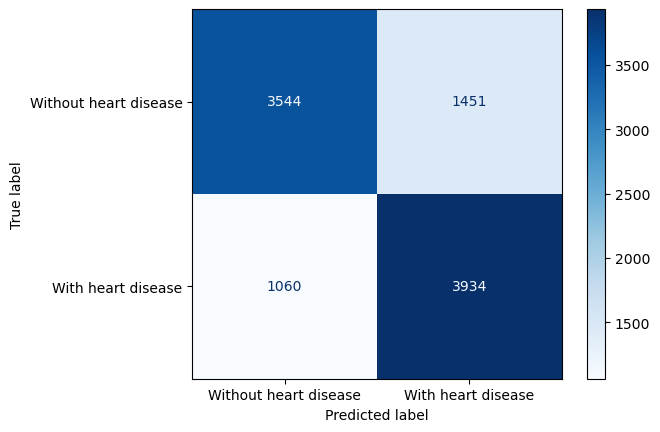

              precision    recall  f1-score      support
0              0.769765  0.709510  0.738410  4995.000000
1              0.730548  0.787745  0.758069  4994.000000
accuracy       0.748623  0.748623  0.748623     0.748623
macro avg      0.750157  0.748627  0.748240  9989.000000
weighted avg   0.750159  0.748623  0.748239  9989.000000


In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = ['Without heart disease', 'With heart disease'])
disp.plot(cmap = "Blues")

plt.show()

lg_report = classification_report(y_test, y_pred, output_dict=True)

lg_report_df = pd.DataFrame(lg_report).T
print(lg_report_df)

In [306]:
lg_report_df

,precision,recall,f1-score,support
0,0.768701,0.693293,0.729053,4995.000000
1,0.720642,0.791350,0.754342,4994.000000
accuracy,0.742317,0.742317,0.742317,0.742317
macro avg,0.744672,0.742321,0.741698,9989.000000
weighted avg,0.744674,0.742317,0.741696,9989.000000


## LIME

In [280]:
lime = LimeTabular(
                   model = logreg, 
                   data=x_train, 
                   random_state=1,
                   )

lime_local = lime.explain_local(x_test[-20:], 
                                y_test[-20:], 
                                name='LIME')

show(lime_local)

<!-- http://127.0.0.1:7001/139926377354416/ -->

# Decision Tree

In [198]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()

params = {
    'max_depth': [2, 4, 6, 8], 
    'min_samples_split': [2, 8, 14, 20, 30], 
    'min_samples_leaf': [2, 8, 14, 20]
}

search = GridSearchCV(clf,                    
                   param_grid = params,   
                   scoring='f1',        
                   cv=10)  

search.fit(x_train, y_train)

print("Tuned Hyperparameters : ", search.best_params_)
print("Accuracy :", search.best_score_)

Tuned Hyperparameters :  {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 14}
Accuracy : 0.7640158505102831


In [57]:
dec_tree = DecisionTreeClassifier(
            max_depth = 6,
            min_samples_leaf = 14,
            min_samples_split = 2
)

dec_tree.fit(x_train, y_train)

y_pred = dec_tree.predict(x_test)
print("Accuracy:", sklearn.metrics.accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred, average = 'macro'))

Accuracy: 0.7562318550405446
F1 Score:  0.7552458832380332


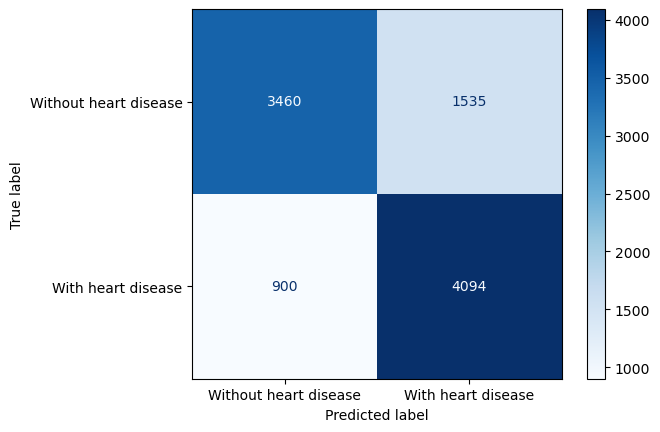

              precision    recall  f1-score      support
0              0.793578  0.692693  0.739711  4995.000000
1              0.727305  0.819784  0.770780  4994.000000
accuracy       0.756232  0.756232  0.756232     0.756232
macro avg      0.760442  0.756238  0.755246  9989.000000
weighted avg   0.760445  0.756232  0.755244  9989.000000


In [58]:
conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = ['Without heart disease', 'With heart disease'])
disp.plot(cmap = "Blues")

plt.show()

dt_report = classification_report(y_test, y_pred, output_dict=True)

dt_report_df = pd.DataFrame(dt_report).T
print(dt_report_df)

In [285]:
dt_report_df

,precision,recall,f1-score,support
0,0.803417,0.668468,0.729756,4995.000000
1,0.716098,0.836404,0.771590,4994.000000
accuracy,0.752428,0.752428,0.752428,0.752428
macro avg,0.759757,0.752436,0.750673,9989.000000
weighted avg,0.759762,0.752428,0.750671,9989.000000


## LIME

In [286]:
lime = LimeTabular(
                   model = dec_tree, 
                   data=x_train, 
                   random_state=1,
                   )

lime_local = lime.explain_local(x_test[-20:], 
                                y_test[-20:], 
                                name='LIME')

show(lime_local)

<!-- http://127.0.0.1:7001/139926226874912/ -->

# Random Forest 

In [59]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced')

rf.fit(x_train, y_train)


y_pred = rf.predict(x_test)
print("Accuracy:", sklearn.metrics.accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred, average = 'macro'))

Accuracy: 0.7586344979477425
F1 Score:  0.7582111037617771


In [195]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

params = {
    'n_estimators' : [25, 50, 100],
    'max_depth': [2, 4, 6, 8] 
}

search = GridSearchCV(rf,                    
                   param_grid = params,   
                   scoring='f1',        
                   cv=10)  

search.fit(x_train, y_train)

print("Tuned Hyperparameters : ", search.best_params_)
print("Accuracy :", search.best_score_)

Tuned Hyperparameters :  {'max_depth': 8, 'n_estimators': 100}
Accuracy : 0.7686201164703309


In [200]:
rf = RandomForestClassifier(
            max_depth = 8,
            n_estimators = 100
)

rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)

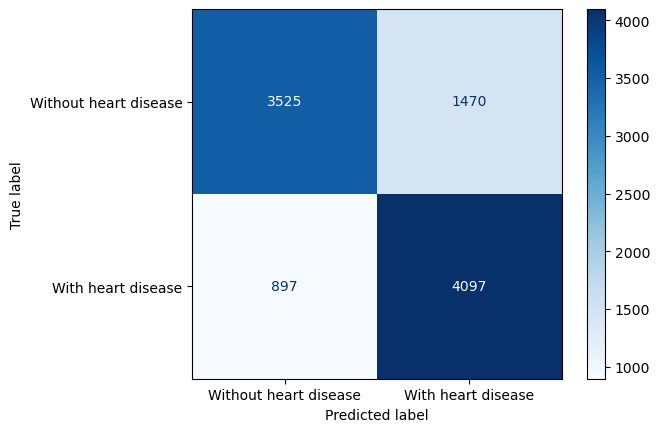

              precision    recall  f1-score      support
0              0.797151  0.705706  0.748646  4995.000000
1              0.735944  0.820384  0.775873  4994.000000
accuracy       0.763039  0.763039  0.763039     0.763039
macro avg      0.766547  0.763045  0.762260  9989.000000
weighted avg   0.766550  0.763039  0.762258  9989.000000


In [201]:
conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = ['Without heart disease', 'With heart disease'])
disp.plot(cmap = "Blues")

plt.show()

rf_report = classification_report(y_test, y_pred, output_dict=True)

rf_report_df = pd.DataFrame(rf_report).T
print(rf_report_df)

In [202]:
rf_report_df

,precision,recall,f1-score,support
0,0.797151,0.705706,0.748646,4995.000000
1,0.735944,0.820384,0.775873,4994.000000
accuracy,0.763039,0.763039,0.763039,0.763039
macro avg,0.766547,0.763045,0.762260,9989.000000
weighted avg,0.766550,0.763039,0.762258,9989.000000


## LIME

In [211]:
lime = LimeTabular(
                   model = rf, 
                   data=x_train, 
                   random_state=1,
                   )

lime_local = lime.explain_local(x_test[60:70], 
                                y_test[60:70], 
                                name='LIME')

show(lime_local)

<!-- http://127.0.0.1:7834/139762853620144/ -->

## SHAP

In [214]:
explainer = shap.TreeExplainer(rf)

start_index = 67
end_index = 68
shap_values = explainer.shap_values(x_test[start_index:end_index])
x_test[start_index:end_index]

,General_Health,Checkup,Age_Category,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption,...,diabetes_No,"diabetes_No, pre-diabetes or borderline diabetes",diabetes_Yes,"diabetes_Yes, but female told only during pregnancy",arthritis_No,arthritis_Yes,sex_Female,sex_Male,smoking_history_No,smoking_history_Yes
228252,3.0,1.0,10.0,165.0,65.77,24.13,30.0,30.0,30.0,4.0,...,1,0,0,0,1,0,1,0,1,0


In [377]:
print(shap_values[0].shape)
shap_values

(1, 28)


[array([[-0.12535323, -0.01087127,  0.18903643, -0.00187758,  0.00517308,
          0.01934524, -0.0086908 , -0.00726949,  0.00761666,  0.00517301,
          0.00435878,  0.00943778, -0.03417544, -0.02879662,  0.00400683,
          0.002928  ,  0.00419534,  0.00268686,  0.01405212,  0.00023542,
          0.01975007,  0.00115947,  0.04051884,  0.03436012,  0.0235487 ,
          0.0172588 ,  0.02970534,  0.01235089]]),
 array([[ 0.12535323,  0.01087127, -0.18903643,  0.00187758, -0.00517308,
         -0.01934524,  0.0086908 ,  0.00726949, -0.00761666, -0.00517301,
         -0.00435878, -0.00943778,  0.03417544,  0.02879662, -0.00400683,
         -0.002928  , -0.00419534, -0.00268686, -0.01405212, -0.00023542,
         -0.01975007, -0.00115947, -0.04051884, -0.03436012, -0.0235487 ,
         -0.0172588 , -0.02970534, -0.01235089]])]

In [215]:
prediction = rf.predict(x_test[start_index:end_index])[0]
print(f"The TF predicted: {prediction}")
shap.force_plot(explainer.expected_value[1],
                         shap_values[1],
                        x_test[start_index:end_index])

The TF predicted: 0


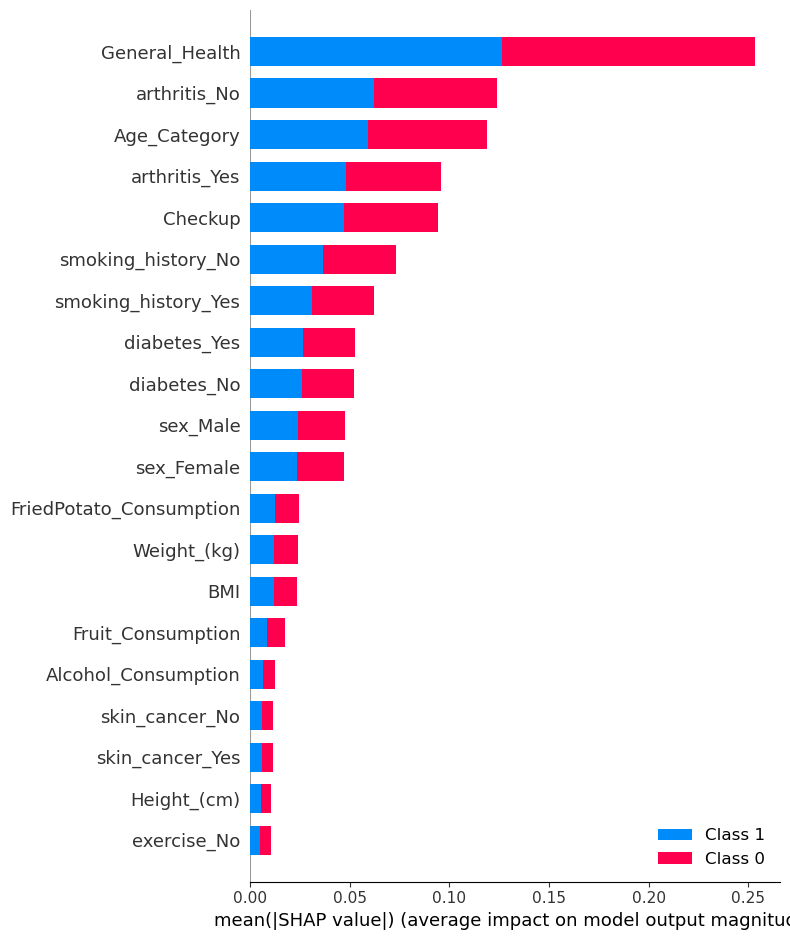

In [87]:
shap.summary_plot(shap_values, x_test)

# KNN

In [199]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

params = {
    'n_neighbors' : np.arange(1, 25),
    'weights' : ('uniform', 'distance'),
    'metric' : ('minkowski', 'chebyshev')
}


search = GridSearchCV(knn,                    
                   param_grid = params,   
                   scoring='f1',        
                   cv=10)  

search.fit(x_train, y_train)

print("Tuned Hyperparameters : ", search.best_params_)
print("Accuracy :", search.best_score_)

Tuned Hyperparameters :  {'metric': 'minkowski', 'n_neighbors': 22, 'weights': 'distance'}
Accuracy : 0.6915170633062921


In [89]:
knn = KNeighborsClassifier(n_neighbors = 24, weights = 'distance', metric = 'minkowski')

knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)
print("Accuracy:", sklearn.metrics.accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred, average = 'macro'))

Accuracy: 0.6826509160076084
F1 Score:  0.6813222152194692


In [90]:
report = classification_report(y_test, y_pred, output_dict=True)

report_df = pd.DataFrame(report).T
print(report_df)

              precision    recall  f1-score      support
0              0.709818  0.618018  0.660745  4995.000000
1              0.661702  0.747297  0.701900  4994.000000
accuracy       0.682651  0.682651  0.682651     0.682651
macro avg      0.685760  0.682657  0.681322  9989.000000
weighted avg   0.685763  0.682651  0.681320  9989.000000


## LIME

In [91]:
lime = LimeTabular(
                   model = knn, 
                   data=x_train, 
                   random_state=1,
                   )

lime_local = lime.explain_local(x_test[-20:], 
                                y_test[-20:], 
                                name='LIME')

show(lime_local)

<!-- http://127.0.0.1:7001/140467003238304/ -->

# XGBClassifier

In [61]:
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier

estimators = [
    #('encoder', TargetEncoder()),
    ('clf', XGBClassifier(random_state=8)) # can customize objective function with the objective parameter
]
pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=8, ...))])

In [62]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

opt = BayesSearchCV(pipe, search_space, cv=3, n_iter=10, scoring='roc_auc', random_state=8) 

In [63]:
opt.fit(x_train, y_train)

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None, gpu_id=None,
                                                       grow_policy=None,
                                                       importance_type=None,
                                                       interaction_constraints=...
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [64]:
opt.best_estimator_

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0.6854728136721551,
                               colsample_bynode=0.9716292421559054,
                               colsample_bytree=0.9999681720272138,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=9.269342703724346,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.4165635668761467, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=5,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=8, ...))])

In [65]:
opt.best_score_

0.8330735690374049

In [66]:
opt.score(x_test, y_test)

0.8371471992617368

In [67]:
y_pred1 = opt.predict(x_test)

In [299]:
opt.predict_proba(x_test)

array([[0.9679212 , 0.03207882],
       [0.78273463, 0.21726538],
       [0.9412653 , 0.05873473],
       ...,
       [0.93448305, 0.06551692],
       [0.9469099 , 0.05309012],
       [0.9402438 , 0.05975624]], dtype=float32)

In [300]:
opt.best_estimator_.steps

[('clf',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=0.6854728136721551,
                colsample_bynode=0.9716292421559054,
                colsample_bytree=0.9999681720272138, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=9.269342703724346, gpu_id=None, grow_policy=None,
                importance_type=None, interaction_constraints=None,
                learning_rate=0.4165635668761467, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=5, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                predictor=None, random_state=8, ...))]

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

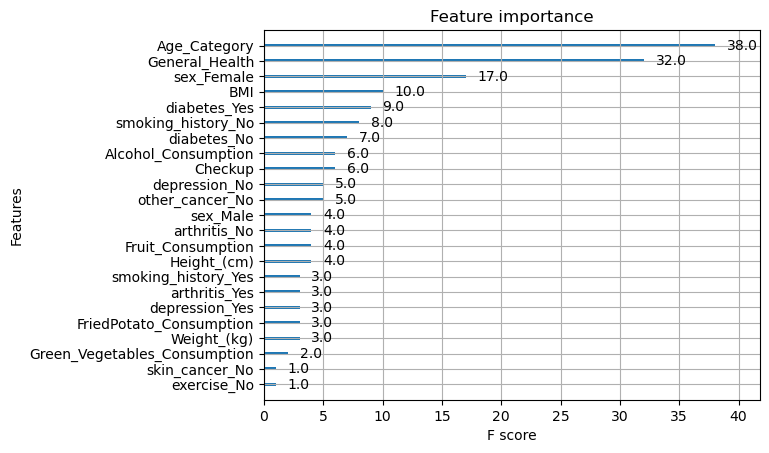

In [68]:
from xgboost import plot_importance

xgboost_step = opt.best_estimator_.steps[0]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model)

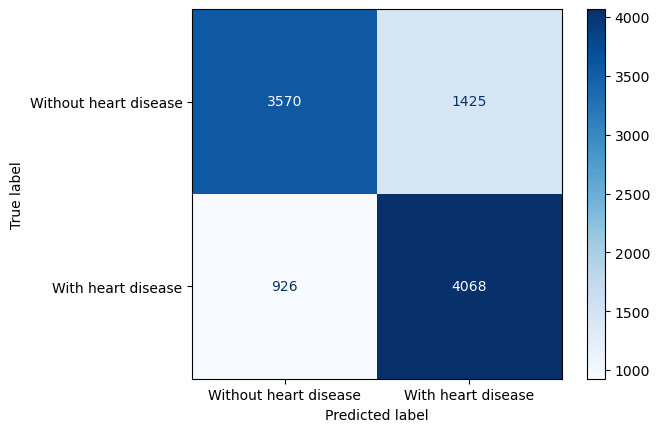

              precision    recall  f1-score      support
0              0.794039  0.714715  0.752292  4995.000000
1              0.740579  0.814577  0.775818  4994.000000
accuracy       0.764641  0.764641  0.764641     0.764641
macro avg      0.767309  0.764646  0.764055  9989.000000
weighted avg   0.767312  0.764641  0.764053  9989.000000


In [69]:
conf_mat = confusion_matrix(y_test, y_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = ['Without heart disease', 'With heart disease'])
disp.plot(cmap = "Blues")

plt.show()

xgb_report = classification_report(y_test, y_pred1, output_dict=True)

xgb_report_df = pd.DataFrame(xgb_report).T
print(xgb_report_df)

In [330]:
xgb_report_df

,precision,recall,f1-score,support
0,0.793402,0.698098,0.742705,4995.000000
1,0.730425,0.818182,0.771817,4994.000000
accuracy,0.758134,0.758134,0.758134,0.758134
macro avg,0.761914,0.758140,0.757261,9989.000000
weighted avg,0.761917,0.758134,0.757260,9989.000000


# Models Comparison

In [71]:
metrics = ['accuracy', 'precision', 'recall', 'f1-score']
logistic_regression = [lg_report_df.precision[2], lg_report_df.precision[3], lg_report_df.recall[3], lg_report_df['f1-score'][3]]
decision_tree = [dt_report_df.precision[2], dt_report_df.precision[3], dt_report_df.recall[3], dt_report_df['f1-score'][3]]
random_forest = [rf_report_df.precision[2], rf_report_df.precision[3], rf_report_df.recall[3], rf_report_df['f1-score'][3]]
xgb_classifier = [xgb_report_df.precision[2], xgb_report_df.precision[3], xgb_report_df.recall[3], xgb_report_df['f1-score'][3]]

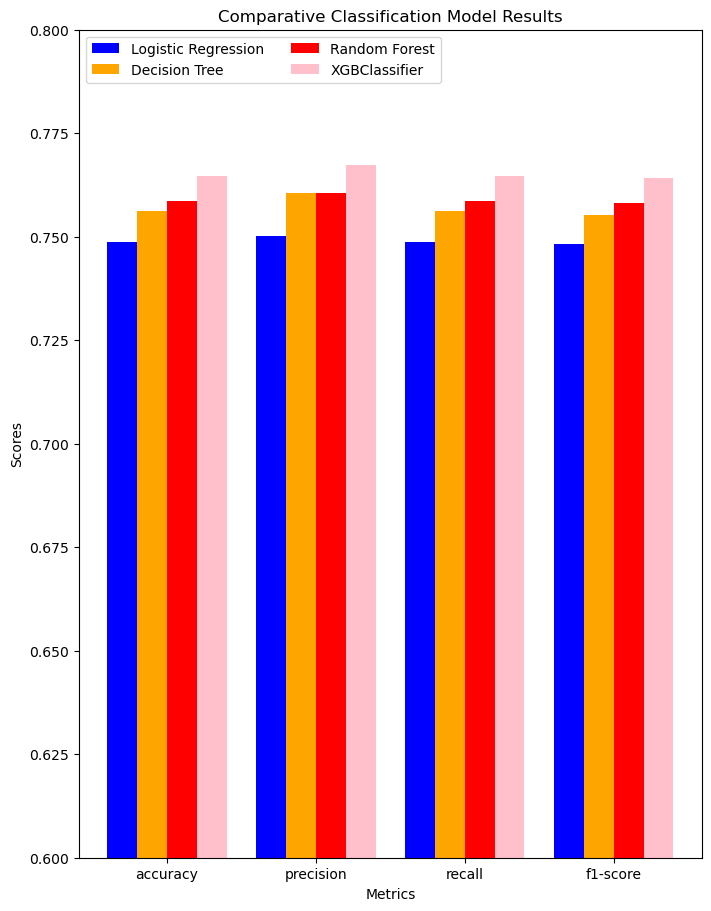

In [73]:
bar_width = 0.2


x = np.arange(len(metrics))

fig, ax = plt.subplots(layout = 'constrained', figsize = (7, 9))

bar1 = ax.bar(x - bar_width/2 - 0.2, logistic_regression, bar_width, label='Logistic Regression', color='b')

bar2 = ax.bar(x - bar_width/2, decision_tree, bar_width, label='Decision Tree', color='orange')

bar3 = ax.bar(x + bar_width/2, random_forest, bar_width, label='Random Forest', color='r')

bar4 = ax.bar(x + bar_width/2 + 0.2, xgb_classifier, bar_width, label='XGBClassifier', color='pink')


ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparative Classification Model Results')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(loc = 'upper left', ncols = 2)

plt.ylim([0.6, 0.8])
plt.show()